# Importing Dependencies

In [1]:
from sklearn.metrics import confusion_matrix, classification_report
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import *
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import random
import cv2
import os


# How Data Looks

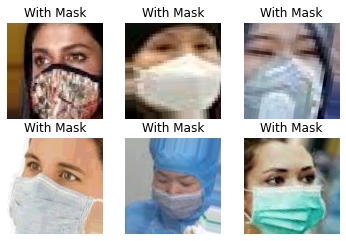

In [2]:
from os import listdir
listdir()
withmask='data/Train/WithMask'
train_images_NC=listdir(withmask)
plt.figure(figsize=(6,6))
for i in range(6):
    plt.subplot(3,3,i+1)
    plt.imshow(plt.imread(os.path.join(withmask,train_images_NC[i])),cmap='gray')
    plt.title('With Mask')
    plt.axis('off')
plt.show()

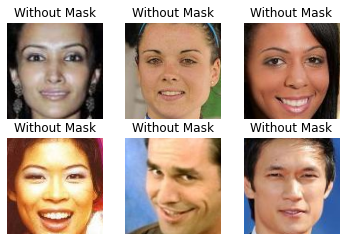

In [3]:
from os import listdir
listdir()
withoutmask='data/Train/WithoutMask'
train_images_NC=listdir(withoutmask)
plt.figure(figsize=(6,6))
for i in range(6):
    plt.subplot(3,3,i+1)
    plt.imshow(plt.imread(os.path.join(withoutmask,train_images_NC[i])),cmap='gray')
    plt.title('Without Mask')
    plt.axis('off')
plt.show()

**Image Counts**

In [4]:
total_train_with_mask = len(os.listdir('data/Train/WithMask'))
total_train_without_mask = len(os.listdir('data/Train/WithoutMask'))
total_test_with_mask = len(os.listdir('data/Test/WithMask'))
total_test_without_mask = len(os.listdir('data/Test/WithoutMask'))
total_val_with_mask = len(os.listdir('data/Validation/WithMask'))
total_val_without_mask = len(os.listdir('data/Validation/WithoutMask'))

print("Train sets images with mask: {}".format(total_train_with_mask))
print('--------------------------------------------')
print("Train sets images without mask: {}".format(total_train_without_mask))
print('--------------------------------------------')
print("Test sets images with mask: {}".format(total_test_with_mask))
print('--------------------------------------------')
print("Test sets images without mask: {}".format(total_test_without_mask))
print('--------------------------------------------')
print("Val sets images with mask: {}".format(total_val_with_mask))
print('--------------------------------------------')
print("Val sets images without mask: {}".format(total_val_without_mask))

Train sets images with mask: 5000
--------------------------------------------
Train sets images without mask: 5000
--------------------------------------------
Test sets images with mask: 483
--------------------------------------------
Test sets images without mask: 509
--------------------------------------------
Val sets images with mask: 400
--------------------------------------------
Val sets images without mask: 400


# Image Proccessing

In [5]:
train_datagen = ImageDataGenerator( horizontal_flip=True,
                                   shear_range=0.2,
                                  rescale= 1./255,
                                  zoom_range=0.2,)

test_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

train_path='data/Train'
test_path = 'data/Test'
val_path = 'data/Validation'

train_set = train_datagen.flow_from_directory(
        train_path,
        target_size=(224,224),
        batch_size=32,
        shuffle = False,
        seed = 42,
         class_mode = "categorical",
        classes = ['WithoutMask','WithMask'])

test_set = test_datagen.flow_from_directory(
        test_path,
        target_size=(224,224),
        seed = 42,
        shuffle = False,
        batch_size=32,
        class_mode = "categorical",
        classes = ['WithoutMask','WithMask'])

val_set = val_datagen.flow_from_directory(
        val_path,
        target_size=(224,224),
        seed = 42,
        shuffle = False,
        batch_size=32,
        class_mode = "categorical",
        classes = ['WithoutMask','WithMask'])

Found 10000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [6]:
train_set.class_indices


{'WithoutMask': 0, 'WithMask': 1}

# After Proccessing

In [7]:
# fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

# for i in range(4):
#     image = next(train_set)[0]
#     image = np.squeeze(image)
#     ax[i].imshow(image)
#     ax[i].axis('off')

# Model Building

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

# MobileNetV2

In [9]:
mobilenet = MobileNetV2(input_shape=(224,224,3),weights = "imagenet", include_top = False)

for layer in mobilenet.layers:
    layer.trainable = False
    

model = Sequential()
model.add(mobilenet)
model.add(Flatten())
model.add(Dense(2,activation='softmax'))
model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 125442    
Total params: 2,383,426
Trainable params: 125,442
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
mobilenet_history = model.fit(train_set,epochs=10,validation_data=val_set)

**Plot**

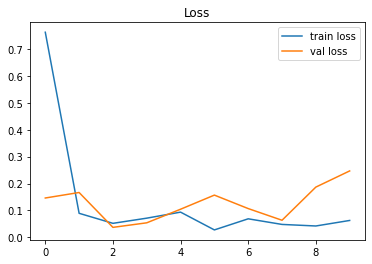

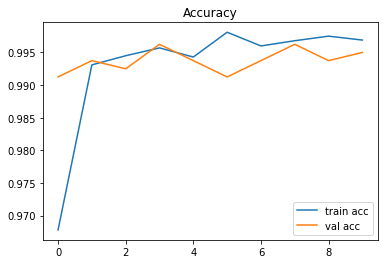

In [ ]:
plt.plot(mobilenet_history.history['loss'], label='train loss')
plt.plot(mobilenet_history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()
plt.show()
#plt.savefig('LossVal_loss')

plt.plot(mobilenet_history.history['accuracy'], label='train acc')
plt.plot(mobilenet_history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()
plt.show()
#plt.savefig('AccVal_acc')

In [ ]:
# Saving model weights
model.save('mobile_net-2.h5')

In [10]:
#Loading saved model weights
model = keras.models.load_model('mobile_net-2.h5')

**Evaluation**

In [11]:
mobilenet_auc = model.evaluate(test_set)

31/31 [==============================] - 22s 722ms/step - loss: 0.0611 - accuracy: 0.9950


In [12]:
test_pred = model.predict(test_set)
test_pred = np.argmax(test_pred,axis = 1)
test_labels = test_set.labels

Text(0.5, 1.0, 'Confusion Matrix - Test Set')

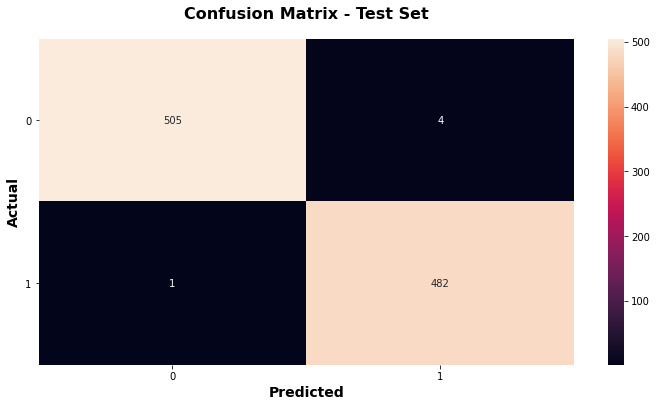

In [13]:
plt.figure(figsize=(12, 6))
ax = sns.heatmap(tf.math.confusion_matrix(
    test_labels,
    test_pred,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
),annot = True,
  fmt="d")
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20)

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(test_labels,test_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       509
           1       0.99      1.00      0.99       483

    accuracy                           0.99       992
   macro avg       0.99      1.00      0.99       992
weighted avg       0.99      0.99      0.99       992



# ResNet50

In [15]:
from tensorflow.keras.applications.resnet import ResNet50 

resnet = ResNet50(include_top=False, 
                  weights='imagenet', 
                  input_shape=(224,224,3))

for layer in resnet.layers:
    layer.trainable = False


model = Sequential()
model.add(resnet)
model.add(Flatten())
model.add(Dense(2,activation='softmax'))
model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 200706    
Total params: 23,788,418
Trainable params: 200,706
Non-trainable params: 23,587,712
_________________________________________________________________


In [16]:
resnet_history = model.fit(train_set,epochs=2,validation_data=val_set)

Epoch 1/2
313/313 [==============================] - 1136s 4s/step - loss: 6.3202 - accuracy: 0.6217 - val_loss: 1.4928 - val_accuracy: 0.6587
Epoch 2/2
313/313 [==============================] - 939s 3s/step - loss: 1.5053 - accuracy: 0.7009 - val_loss: 0.2825 - val_accuracy: 0.8763


**Plot**

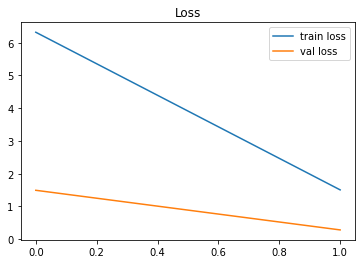

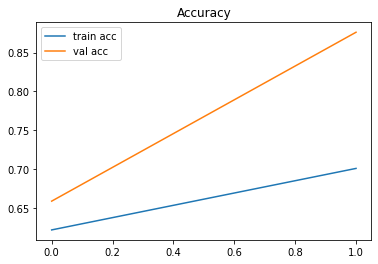

In [17]:
plt.plot(resnet_history.history['loss'], label='train loss')
plt.plot(resnet_history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()
plt.show()
#plt.savefig('LossVal_loss')

plt.plot(resnet_history.history['accuracy'], label='train acc')
plt.plot(resnet_history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()
plt.show()
#plt.savefig('AccVal_acc')

In [18]:
# Saving model weights
model.save('Resnet50-2.h5')

#Loading saved model weights
model = keras.models.load_model('Resnet50-2.h5')

**Evaluation**

In [19]:
resnet_auc = model.evaluate(test_set)

31/31 [==============================] - 82s 3s/step - loss: 0.2631 - accuracy: 0.8982


In [20]:
test_pred = model.predict(test_set)
test_pred = np.argmax(test_pred,axis = 1)
test_labels = test_set.labels

Text(0.5, 1.0, 'Confusion Matrix - Test Set')

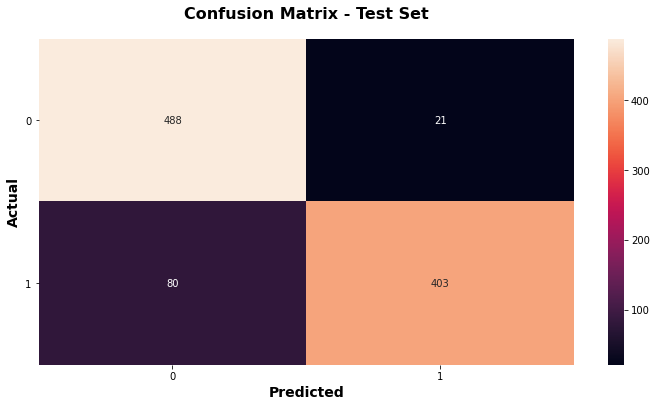

In [21]:
plt.figure(figsize=(12, 6))
ax = sns.heatmap(tf.math.confusion_matrix(
    test_labels,
    test_pred,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None,
),annot = True,
  fmt="d")
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20)

In [22]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(test_labels,test_pred))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91       509
           1       0.95      0.83      0.89       483

    accuracy                           0.90       992
   macro avg       0.90      0.90      0.90       992
weighted avg       0.90      0.90      0.90       992



# **InceptionV3 / GoogleNet**

In [23]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

inception = InceptionV3(include_top=False, 
                  weights='imagenet', 
                  input_shape=(224,224,3))

for layer in inception.layers:
    layer.trainable = False


model = Sequential()
model.add(inception)
model.add(Flatten())
model.add(Dense(2,activation='softmax'))
model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 102402    
Total params: 21,905,186
Trainable params: 102,402
Non-trainable params: 21,802,784
_________________________________________________________________


In [24]:
inception_history = model.fit(train_set,epochs=2,validation_data=val_set)

Epoch 1/2
313/313 [==============================] - 831s 3s/step - loss: 0.6353 - accuracy: 0.9747 - val_loss: 0.0184 - val_accuracy: 0.9987
Epoch 2/2
313/313 [==============================] - 1080s 3s/step - loss: 0.0285 - accuracy: 0.9976 - val_loss: 3.9188e-05 - val_accuracy: 1.0000


**Plot**

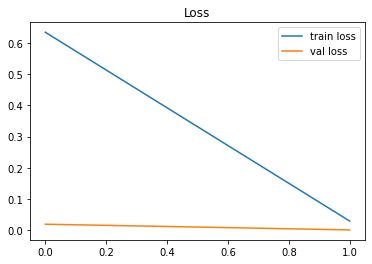

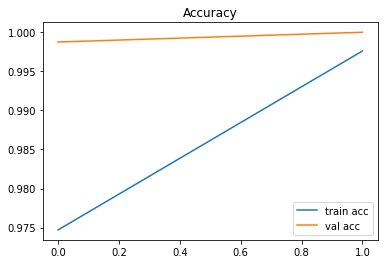

In [25]:
plt.plot(inception_history.history['loss'], label='train loss')
plt.plot(inception_history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()
plt.show()
#plt.savefig('LossVal_loss')

plt.plot(inception_history.history['accuracy'], label='train acc')
plt.plot(inception_history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()
plt.show()
#plt.savefig('AccVal_acc')

In [26]:
# Saving model weights
model.save('InceptionV3-2.h5')

#Loading saved model weights
model = keras.models.load_model('InceptionV3-2.h5')

**Evaluation**

In [27]:
inception_auc = model.evaluate(test_set)

31/31 [==============================] - 98s 3s/step - loss: 0.0082 - accuracy: 0.9970


In [28]:
test_pred = model.predict(test_set)
test_pred = np.argmax(test_pred,axis = 1)
test_labels = test_set.labels

Text(0.5, 1.0, 'Confusion Matrix - Test Set')

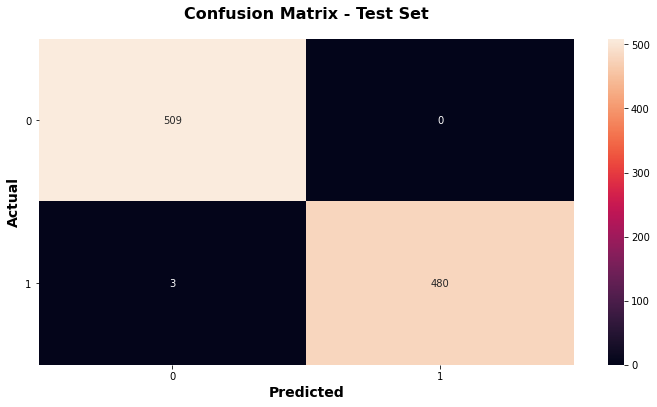

In [29]:
plt.figure(figsize=(12, 6))
ax = sns.heatmap(tf.math.confusion_matrix(
    test_labels,
    test_pred,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None,
),annot = True,
  fmt="d")
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20)

In [30]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(test_labels,test_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       509
           1       1.00      0.99      1.00       483

    accuracy                           1.00       992
   macro avg       1.00      1.00      1.00       992
weighted avg       1.00      1.00      1.00       992



# Custom CNN

In [ ]:
from keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten

In [ ]:
model = Sequential()

model.add(layers.Conv2D(64,(3,3),activation='relu',strides=2 ,input_shape=(224,224,3)))
model.add(layers.Conv2D(128,(3,3),activation='relu',strides=2))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32,(3,3),activation='relu',strides=1))
model.add(layers.Conv2D(64,(3,3),activation='relu',strides=1))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2,'softmax'))

model.summary()

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_94 (Conv2D)           (None, 111, 111, 64)      1792      
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 55, 55, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 27, 128)       0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 25, 25, 32)        36896     
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 23, 23, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 64)       

In [ ]:
cnn_history = model.fit(train_set,epochs=10,validation_data=val_set)

Epoch 1/10
313/313 [==============================] - 138s 435ms/step - loss: 0.5596 - accuracy: 0.7256 - val_loss: 0.2321 - val_accuracy: 0.9275
Epoch 2/10
313/313 [==============================] - 135s 431ms/step - loss: 0.2388 - accuracy: 0.9051 - val_loss: 0.1989 - val_accuracy: 0.9150
Epoch 3/10
313/313 [==============================] - 139s 443ms/step - loss: 0.1944 - accuracy: 0.9277 - val_loss: 0.1420 - val_accuracy: 0.9588
Epoch 4/10
313/313 [==============================] - 136s 434ms/step - loss: 0.2344 - accuracy: 0.9091 - val_loss: 0.1478 - val_accuracy: 0.9513
Epoch 5/10
313/313 [==============================] - 135s 433ms/step - loss: 0.1614 - accuracy: 0.9345 - val_loss: 0.0940 - val_accuracy: 0.9663
Epoch 6/10
313/313 [==============================] - 140s 446ms/step - loss: 0.1038 - accuracy: 0.9621 - val_loss: 0.0551 - val_accuracy: 0.9825
Epoch 7/10
313/313 [==============================] - 139s 443ms/step - loss: 0.0793 - accuracy: 0.9722 - val_loss: 0.0442 -

**Plot**

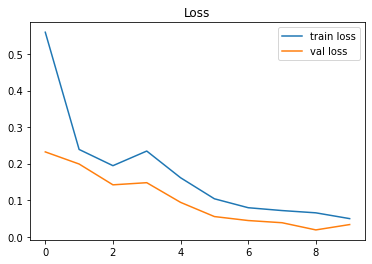

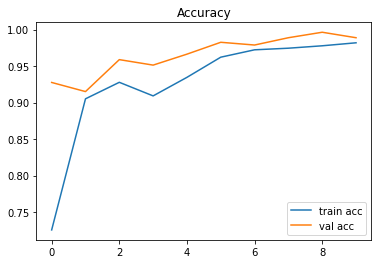

In [ ]:
plt.plot(cnn_history.history['loss'], label='train loss')
plt.plot(cnn_history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()
plt.show()
#plt.savefig('LossVal_loss')

plt.plot(cnn_history.history['accuracy'], label='train acc')
plt.plot(cnn_history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()
plt.show()
#plt.savefig('AccVal_acc')

In [31]:
# Saving model weights
model.save('Custom_CNN-2.h5')

#Loading saved model weights
model = keras.models.load_model('Custom_CNN-2.h5')

**Evaluation**

In [32]:
cnn_auc = model.evaluate(test_set)

31/31 [==============================] - 12s 387ms/step - loss: 0.2085 - accuracy: 0.9183


In [33]:
test_pred = model.predict(test_set)
test_pred = np.argmax(test_pred,axis = 1)
test_labels = test_set.labels

Text(0.5, 1.0, 'Confusion Matrix - Test Set')

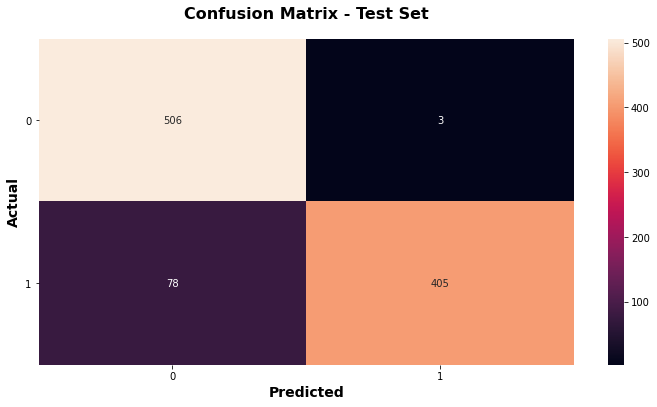

In [34]:
plt.figure(figsize=(12, 6))
ax = sns.heatmap(tf.math.confusion_matrix(
    test_labels,
    test_pred,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None,
),annot = True,
  fmt="d")
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20)

In [35]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(test_labels,test_pred))

              precision    recall  f1-score   support

           0       0.87      0.99      0.93       509
           1       0.99      0.84      0.91       483

    accuracy                           0.92       992
   macro avg       0.93      0.92      0.92       992
weighted avg       0.93      0.92      0.92       992



# Prediction with CNN

In [ ]:
def predict(path):

    img = cv2.imread(path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224),interpolation=cv2.INTER_NEAREST)
    plt.axis('off')
    plt.imshow(img)
    img = np.expand_dims(img,axis=0)
    predict = model.predict(img)
    predict = np.argmax(predict,axis = 1)

    if predict == 1:
      print('With Mask')
    else:
      print('No Mask')



In [ ]:
predict('filepath.jpg')

# Comparing All models

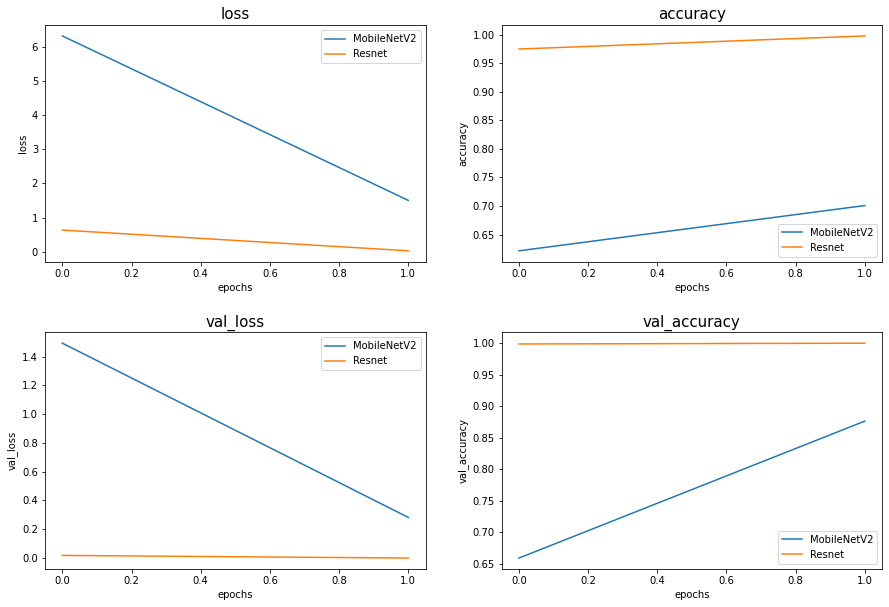

In [37]:
model_hist = [mobilenet_history,resnet_history,inception_history,cnn_history]
names = ['MobileNetV2','Resnet','InceptionV3','CNN']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.3)
for metric in model_hist[0].history:
    index = list(model_hist[0].history).index(metric)
    ax = axes.flatten()[index]
    name_index = 0
    for history in model_hist:
        ax.plot(history.history[metric], label=names[name_index])
        name_index += 1
    ax.set_title(metric, size=15)
    ax.set_xlabel('epochs')
    ax.set_ylabel(metric)
    ax.legend()
plt.show()

In [ ]:
data={'Nets':['MobileNetV2','Resnet','InceptionV3','CNN'],
      'Accuracy':[mobilenet_auc[1],resnet_auc[1],inception_auc[1],cnn_auc[1]]}

df =pd.DataFrame(data)

df.sort_values('Accuracy', ascending=False)

,Nets,Accuracy
2,InceptionV3,0.995968
0,MobileNetV2,0.992944
3,CNN,0.979839
1,Resnet,0.865927
